## The problem

- Walking around in a 2D maze, with walls put in random locations

Things to try next:

- Figure out the Q values, see if there's an error there
- Directly penalize walking into walls

In [1]:
import gym
from gym.spaces import Discrete
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.preprocessors import get_preprocessor 
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
import torch

In [3]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "right",
    3 : "left"
}

In [4]:
ray.init(ignore_reinit_error=True)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:62104',
 'object_store_address': '/tmp/ray/session_2022-03-31_10-50-42_636752_94597/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-31_10-50-42_636752_94597/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-31_10-50-42_636752_94597',
 'metrics_export_port': 64036,
 'gcs_address': '127.0.0.1:63884',
 'node_id': 'b16d206cd5ed94b6d864e3b694d34b52145ff5b27abe88ea94d30b4c'}

In [5]:
class RandomMazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        
        # show entire state, not just nearby the player
        # self.observation_space = gym.spaces.Dict({
        #     "player" : gym.spaces.Discrete(self.ylen*self.xlen),
        #     "walls" : gym.spaces.MultiBinary(self.ylen*self.xlen)
        # })
        # self.observation_space = gym.spaces.MultiBinary([2, self.ylen, self.xlen])

        # see https://docs.ray.io/en/latest/rllib/rllib-models.html
        # looks like they mainly just preprocess discrete/multidiscrete and atari?
        # what about box?? hmm. i guess those go without preproc?
        
        # self.observation_space = gym.spaces.MultiDiscrete([2,2,2,2])
        # self.observation_space = gym.spaces.Tuple([Discrete(2), Discrete(2), Discrete(2), Discrete(2)])
        self.observation_space = gym.spaces.MultiBinary(4)
        
        self.seed = env_config.get("random_seed", None)
    
    def reset(self, seed=None):
        # print("RESET")
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        
        if self.seed is not None: # fixed seed every time, not random maze
            np.random.seed(self.seed)
        
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self): # SWAPPED FROM THE ABOVE ONE
        # make the observation into the entire state??
        # playerstate = self.player[1] + self.xlen*self.player[0]
        # obsdict = {
        #     "player" : playerstate,
        #     "walls" : self.wallsstate
        # }
        # return obsdict
        
        # playerstate = 0*self.walls
        # playerstate[self.player] = 1
        # return np.concatenate((playerstate[None], 
        #                        self.walls[None]), axis=0).astype(int)
        i, j = self.player

        obs = []
        obs.append(1 if i==0           else self.walls[i-1,j]) # up
        obs.append(1 if i==self.ylen-1 else self.walls[i+1,j]) # down
        obs.append(1 if j==0           else self.walls[i,j-1]) # left
        obs.append(1 if j==self.xlen-1 else self.walls[i,j+1]) # right
        return np.array(obs, dtype=int)
        # 3x3 context, 8 observations
        # wallsexit = self.walls.copy()
        # wallspad = np.pad(wallsexit, 1, constant_values=1) # pad with 1 to simulate walls all around
        # nearby = wallspad[self.player[0]:self.player[0]+3, self.player[1]:self.player[1]+3]
        # nearbyflat = nearby.flatten()
        # minus_middle = np.concatenate((nearbyflat[:4], nearbyflat[5:]))
        # return minus_middle
        # NW N NE W E SW S SE
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
                
        elif action == 2: # move left
            new_loc = (self.player[0], self.player[1]-1)
  
        elif action == 3: # move right
            new_loc = (self.player[0], self.player[1]+1)
                
        else:
            raise Exception("Action must be {0,1,2,3}")
            
        # update state if you are able to move
        move_success = False
        if 0 <= new_loc[0] < self.ylen and 0 <= new_loc[1] < self.xlen and not self.walls[new_loc]:
            self.player = new_loc
            move_success = True
                
        info = {"player pos" : self.player}
        
        # reward
        distance = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        reward = -distance
        
        # penalize walking into walls
        if not move_success:
            reward -= 5
        
        return self.get_observation(), reward, self.is_done(), info

    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [6]:
rme = RandomMazeEnvironment({})

In [7]:
rme.reset()

array([1, 0, 1, 1])

In [8]:
rme.render()

PX...
.....
...X.
.....
..X.E


In [9]:
rme.step(0)

(array([1, 0, 1, 1]), -13, False, {'player pos': (0, 0)})

In [10]:
# trainer_config_2 = copy.copy(trainer_config)
# trainer_config_2["model"] = {"fcnet_hiddens" : [64, 64]}

In [11]:
trainer_config_rme = {
    # "num_workers": 0,
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    # "create_env_on_driver" : True,
    "log_level" : "ERROR",
    "framework" : "torch", # default is tf
    "_disable_preprocessor_api" : True
}

In [12]:
trainer = PPOTrainer(trainer_config_rme, env=RandomMazeEnvironment) # DQNTrainer

2022-03-31 10:50:45,761	WARNING trainer.py:2279 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-03-31 10:50:45,762	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-31 10:50:45,762	INFO trainer.py:790 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


In [13]:
rewards = []

In [14]:
for episode in range(20):
    print(episode)
    out = trainer.train();
    rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


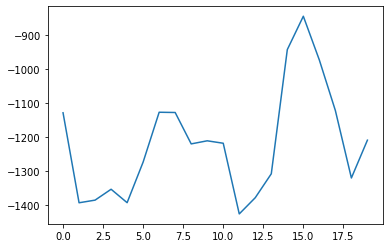

In [15]:
plt.plot(rewards);

In [16]:
trainer.evaluate()

{'evaluation': {'episode_reward_max': -70.0,
  'episode_reward_min': -2705.0,
  'episode_reward_mean': -430.4,
  'episode_len_mean': 76.6,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-542.0,
    -145.0,
    -170.0,
    -178.0,
    -74.0,
    -2705.0,
    -196.0,
    -73.0,
    -70.0,
    -151.0],
   'episode_lengths': [74, 22, 31, 29, 14, 500, 37, 15, 12, 32]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.049085629499253894,
   'mean_inference_ms': 0.2675131060464752,
   'mean_action_processing_ms': 0.015823284681337597,
   'mean_env_wait_ms': 0.019932352734979782,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

## Questions

- Why does it say episode lengths are always 500 when it clearly seems to work (below)?
- How many episodes are actually getting run during training/evaluation? Only 10?
- `compute_action` vs `compute_single_action` 
- When I do `dist.sample()`, why do I get numbers larger than 3?
- And, why is `model_output` size 64 instead of 4?
- Can we go through the results of `print(model)` and understand why it looks the way it does?
- Higher-level question: in my google doc I have a list of envs for the tuned examples - which ones would be good for the course? can they be rendered?

In [17]:
rme = RandomMazeEnvironment({})
obs = rme.reset() 
rme.render()

PX...
...X.
..X..
...X.
...XE


In [18]:
action = trainer.compute_action(input_dict={"obs": obs}, explore=False)
res = rme.step(action)
obs = res[0]
rme.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])
print("obs:", obs)

.X...
P..X.
..X..
...X.
...XE

action: down
reward: -7
done: False
obs: [0 0 1 0]


In [19]:
policy = trainer.get_policy()
model = policy.model

In [20]:
model_output = model({"obs": torch.from_numpy(obs)})[0]

In [21]:
model_output

tensor([[-0.8925,  0.5395, -0.7555,  0.8846]], grad_fn=<AddmmBackward0>)

In [22]:
q_values = model.get_q_value_distributions(model_output)

AttributeError: 'ComplexInputNetwork' object has no attribute 'get_q_value_distributions'

In [ ]:
q_values

In [ ]:
list(trainer.get_policy().get_weights().values())[0].shape

Idea: give the agent an action that says "give up", take a reward hit, but move on.
So basically, see if they can figure out if it's unsolvable.

In [ ]:
dist = policy.dist_class(model_output, model) 
dist

In [ ]:
dist.sample()

In [ ]:
dist.dist

In [ ]:
print(model)